## Implementación de 1-n NQK con D=9 sin PCA Original Scheme

### I) Data re-uploading QNN (de 1 qubit, 9 features, 6 capas)

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import matplotlib.pyplot as plt

#Semilla
np.random.seed(42)

# Función para calcular la matriz de densidad
def density_matrix(state):
    """Calcula la matriz de densidad a partir de un vector de estado  

    Args:
        state (array[complex]): arreglo que representa el vector de estado
    Returns:
        dm: (array[complex]): arreglo que representa la matriz de densidad
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

Circuito del QNN con data reloading y fidelity

In [2]:
dev = qml.device("lightning.qubit", wires=1)


@qml.qnode(dev)
def qcircuit(params, x, y):
    """Circuito variacional con data reloading.

    Args:
        params (array[float]): arreglo de parámetros
        x (array[float]): input
        y (array[float]): etiquetas

    Returns:
        float: fidelity entre la salida del circuito y la etiqueta
    """
    x1=x[:3]
    x2=x[3:6]
    x3=x[6:9]
    for p in params:
        p1=p[:3]
        p2=p[3:6]
        p3=p[6:9]
        qml.Rot(*x1, wires=0)
        qml.Rot(*p1, wires=0)
        qml.Rot(*x2, wires=0)
        qml.Rot(*p2, wires=0)
        qml.Rot(*x3, wires=0)
        qml.Rot(*p3, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Función de costo

    Args:
        params (array[float]): arreglo de parámetros
        x (array[float]): 2-d arreglo de inputs
        y (array[float]): 1-d arreglo de etiquetas
        state_labels (array[float]): arreglo de etiquetas como vectores de estado

    Returns:
        float: costo promedio sobre el batch
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

Testeo y batches

In [3]:
def test(params, x, y, state_labels=None):
    """
    Testea en un conjunto de datos dado los parámetros del circuito

    Args:
        params (array[float]): arreglo de parametros
        x (array[float]): 2-d arreglo de input vectors
        y (array[float]): 1-d arreglo de targets
        state_labels (array[float]): 1-d arreglo de representaciones de estado para las etiquetas
    Returns:
        predicted (array([int]): labels predichas para los datos de test
        output_states (array[float]): estados cuanticos de salida del circuito
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Precisión de la clasificación 

    Args:
        y_true (array[float]): 1-d arreglo de targets
        y_predicted (array[float]): 1-d arreglo de predicciones
        state_labels (array[float]): 1-d arreglo de representaciones de estado para las etiquetas

    Returns:
        score (float): fraccion de muestras clasificadas correctamente
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    generador de batches

    Args:
        inputs (array[float]): data de entrada
        targets (array[float]): targets

    Returns:
        inputs (array[float]): un batch de inputs de longitud `batch_size`
        targets (array[float]): un batch de targets de longitud `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

Entrenamiento del qnn (k=1)

In [4]:
#Datos de entrenamiento y test
import pandas as pd
from sklearn.model_selection import train_test_split

data=pd.read_csv('Preprocesamiento\sample1.csv')
Xdata=data[['r1','phi1','z1','r2','phi2','z2','r3','phi3','z3']].values
Ydata=(data['label'].values).astype(int)

#Division para 1 ejemplo:
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.1, random_state=42)
X_train = np.array(X_train, requires_grad=False)
X_test = np.array(X_test, requires_grad=False)
y_train = np.array(y_train, requires_grad=False)
y_test = np.array(y_test, requires_grad=False)

In [5]:
# Entrenamiento del circuito clasificador
num_layers = 6
learning_rate = 0.01
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)


# Inicializacion con parametros aleatorios
params = np.random.uniform(size=(num_layers, 9), requires_grad=True)
predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# guardamos las predicciones con pesos aleatorios para comparación
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

Epoch:  0 | Cost: 0.375606 | Train accuracy: 0.480833 | Test Accuracy: 0.437500


Entrenamiento con batchs=32

In [18]:
import time
max_accuracy=0
inicio_0=time.time()

for it in range(epochs):
    inicio=time.time()
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    if accuracy_test>max_accuracy:
        max_accuracy=accuracy_test
        max_params=params
    fin=time.time()
    print("Tiempo de epoch:",fin-inicio,"segundos")
    print("-------------------------------------------------------------------")

fin_0=time.time()
print("Tiempo total de entrenamiento:",(fin_0-inicio_0)/60," minutos")
print("Mejor accuracy de test:",max_accuracy)
print("Mejores parametros:",max_params)
params_opt=max_params

Epoch:  1 | Loss: 0.301782 | Train accuracy: 0.552222 | Test accuracy: 0.507500
Tiempo de epoch: 92.59916734695435 segundos
-------------------------------------------------------------------
Epoch:  2 | Loss: 0.291924 | Train accuracy: 0.563056 | Test accuracy: 0.542500
Tiempo de epoch: 89.12661170959473 segundos
-------------------------------------------------------------------
Epoch:  3 | Loss: 0.286156 | Train accuracy: 0.569167 | Test accuracy: 0.522500
Tiempo de epoch: 80.47225999832153 segundos
-------------------------------------------------------------------
Epoch:  4 | Loss: 0.282432 | Train accuracy: 0.574167 | Test accuracy: 0.525000
Tiempo de epoch: 85.34200263023376 segundos
-------------------------------------------------------------------
Epoch:  5 | Loss: 0.279376 | Train accuracy: 0.575000 | Test accuracy: 0.550000
Tiempo de epoch: 90.01938271522522 segundos
-------------------------------------------------------------------
Epoch:  6 | Loss: 0.276230 | Train accur

Entrenamiento full batch

In [ ]:
import time
max_accuracy=0
inicio_0=time.time()
for it in range(epochs):
    inicio=time.time()
    params, _, _, _ = opt.step(cost, params, X_train, y_train, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    if accuracy_test>max_accuracy:
        max_accuracy=accuracy_test
        max_params=params
    fin=time.time()
    print("Tiempo de epoch:",fin-inicio,"segundos")
    print("Parametros:",params)
    print("-------------------------------------------------------------------")
fin_0=time.time()
print("Tiempo total de entrenamiento:",(fin_0-inicio_0)/60," minutos")
print("Mejor accuracy de test:",max_accuracy)
print("Mejores parametros:",max_params)

Epoch:  1 | Loss: 0.344213 | Train accuracy: 0.485556 | Test accuracy: 0.440000
Tiempo de epoch: 89.60263967514038 segundos
Parametros: [[ 0.8065417   0.19342861  0.78968991  0.58685047  0.45583247  0.08997518
   0.46924764  0.34370832  0.15285763]
 [ 0.66088296  0.04641197  0.73199553  0.9485518  -0.00921356  1.00221065
   0.60748187  0.62165285 -0.00293344]
 [ 0.03306169  0.53477414  0.40986056  0.0366659   0.98375534  0.22277153
   0.10060601  0.62838577  0.39246157]
 [ 0.97323112  0.45676344  0.8499407   0.69030733  0.46049836  0.02326476
   0.93220221  0.55328852  0.37541726]
 [ 0.0259661   0.22090031  0.25102528  0.67326546  0.59999709  0.84319431
   0.16336727  0.40105959  0.17223681]
 [ 0.76536075  0.43515567  0.21794012  0.57769898  0.02131409  0.85228354
   0.45974911  0.38515051  0.92665887]]
-------------------------------------------------------------------
Epoch:  2 | Loss: 0.340699 | Train accuracy: 0.493889 | Test accuracy: 0.445000
Tiempo de epoch: 92.68284106254578 se

Finalizado:

In [9]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
learned_params = params
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

Cost: 0.272582 | Train accuracy 0.592778 | Test Accuracy : 0.565000
Learned weights
Layer 0: [ 1.02613132 -0.11752837  1.02925411  1.03942302  1.70190266 -0.19238458
  0.46441504  0.1721257  -0.11664077]
Layer 1: [ 0.59090649  0.27063389  0.59119711  0.74758521 -0.11646081  0.88712538
  0.74166144  0.82463246  0.10434261]
Layer 2: [ 0.162253   -0.07234518  0.46583626 -0.01208345  1.75471669  0.60361382
 -0.08541768  0.66519576  0.15001898]
Layer 3: [ 1.05036303  0.20750207  0.82150145  0.92777726  0.62173037  0.5840884
  1.06156839 -0.01975438  0.63869404]
Layer 4: [ 0.39686765  0.17163042  0.1988242   0.71863759  0.77610531  0.73860679
  0.32937961  0.89546091 -0.5577777 ]
Layer 5: [ 0.97830194  0.45910501  0.11986843  0.72410353  0.12466627  1.13397146
 -0.73730946  0.40691386  0.92665887]


### II) 1-n EQK 

Embedding con parámetros aprendidos del QNN

In [6]:

def circuito_embedding(params, x, n):
    x1=x[:3]
    x2=x[3:6]
    x3=x[6:9]
    for p in params:
        p1=p[:3]
        p2=p[3:6]
        p3=p[6:9]
        #Rotaciones
        for i in range(n):
            qml.Rot(*x1, wires=i)
            qml.Rot(*p1, wires=i)
            qml.Rot(*x2, wires=i)
            qml.Rot(*p2, wires=i)
            qml.Rot(*x3, wires=i)
            qml.Rot(*p3, wires=i)
        
        #cascada de E (cnots)
        for i in range(n-1): qml.CNOT(wires=[i,i+1]) 


#adjunto

adjunto_empedding=qml.adjoint(circuito_embedding)

n=3
dev3 = qml.device("lightning.qubit", wires=n)
wires = dev3.wires.tolist()

@qml.qnode(dev3)
def circuito_kernel(x1,x2, params,n):
    circuito_embedding(params, x1, n)
    adjunto_empedding(params, x2, n)
    return qml.probs(wires=wires)

In [8]:
params = np.random.uniform(size=(num_layers, 9), requires_grad=True)

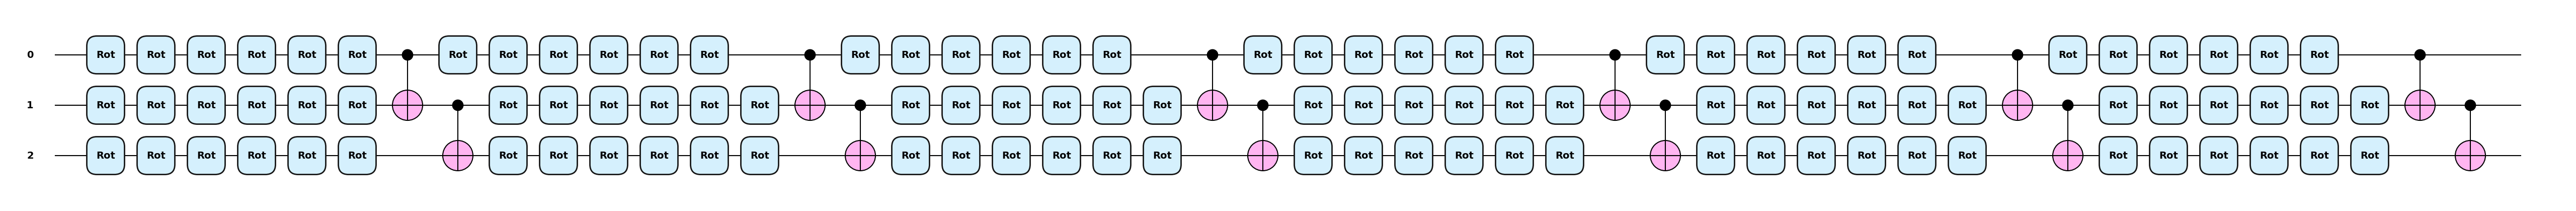

In [10]:
qml.draw_mpl(circuito_embedding, style= 'pennylane' )(params, X_train[0], n)
plt.show()

Valor de kernel

In [27]:
def kernel(x1, x2, params,n):
    return circuito_kernel(x1, x2, params,n)[0]

In [ ]:
#Probando kernel entre 2 puntos
kernel(X_train[0], X_train[1], params_opt, n)

np.float64(0.24192601919203888)

Construyendo matriz kernel

In [24]:
init_kernel = lambda x1, x2: kernel(x1, x2,params_opt, n)
K_matrix = qml.kernels.square_kernel_matrix(X_train, init_kernel,assume_normalized_kernel=True)
K_matrix.size

KeyboardInterrupt: 

#### Usando matriz NQK kernel en SVC

In [29]:
from sklearn.svm import SVC

#### Matriz NQK kernel en SVC

In [30]:
svm = SVC(kernel=lambda  X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train,y_train) 

KeyboardInterrupt: 

Accuracy medida

In [ ]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

nqk_accuracy = accuracy(svm, X_test, y_test)

Comparación de performances

In [ ]:
print("Test accuracy de QNN: ", accuracy_test)
print(f"Test accuracy de 1 to {n} NQK : {nqk_accuracy}")

Test accuracy de QNN:  0.64
Test accuracy de 1 to 3 NQK : 0.76


Se espera normalmente que el NQK tenga mayor o igual precision que el QNN. La precision está baja porque se usaron muy pocos datos de entrenamiento (deberian ser del orden de 1000) porque construir la matriz Kernel crece con O(n^2) y demora mucho en mi laptop para valores altos, quiza deberia probar en alguna pc de la facu.

### Entrenamiento k-folding de flujo completo

In [ ]:

# --- QNN 1 qubit data reuploading ---

import pennylane as qml 
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

#Semilla
np.random.seed(42)

# Función para calcular la matriz de densidad
def density_matrix(state):
    """Calcula la matriz de densidad a partir de un vector de estado  

    Args:
        state (array[complex]): arreglo que representa el vector de estado
    Returns:
        dm: (array[complex]): arreglo que representa la matriz de densidad
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

#Circuito del QNN con data reloading y fidelity

dev = qml.device("lightning.qubit", wires=1)


@qml.qnode(dev)
def qcircuit(params, x, y):
    """Circuito variacional con data reloading.

    Args:
        params (array[float]): arreglo de parámetros
        x (array[float]): input
        y (array[float]): etiquetas

    Returns:
        float: fidelity entre la salida del circuito y la etiqueta
    """
    x1=x[:3]
    x2=x[3:6]
    x3=x[6:9]
    for p in params:
        p1=p[:3]
        p2=p[3:6]
        p3=p[6:9]
        qml.Rot(*x1, wires=0)
        qml.Rot(*p1, wires=0)
        qml.Rot(*x2, wires=0)
        qml.Rot(*p2, wires=0)
        qml.Rot(*x3, wires=0)
        qml.Rot(*p3, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Función de costo

    Args:
        params (array[float]): arreglo de parámetros
        x (array[float]): 2-d arreglo de inputs
        y (array[float]): 1-d arreglo de etiquetas
        state_labels (array[float]): arreglo de etiquetas como vectores de estado

    Returns:
        float: costo promedio sobre el batch
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

#Testeo y batches
def test(params, x, y, state_labels=None):
    """
    Testea en un conjunto de datos dado los parámetros del circuito

    Args:
        params (array[float]): arreglo de parametros
        x (array[float]): 2-d arreglo de input vectors
        y (array[float]): 1-d arreglo de targets
        state_labels (array[float]): 1-d arreglo de representaciones de estado para las etiquetas
    Returns:
        predicted (array([int]): labels predichas para los datos de test
        output_states (array[float]): estados cuanticos de salida del circuito
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Precisión de la clasificación 

    Args:
        y_true (array[float]): 1-d arreglo de targets
        y_predicted (array[float]): 1-d arreglo de predicciones
        state_labels (array[float]): 1-d arreglo de representaciones de estado para las etiquetas

    Returns:
        score (float): fraccion de muestras clasificadas correctamente
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    generador de batches

    Args:
        inputs (array[float]): data de entrada
        targets (array[float]): targets

    Returns:
        inputs (array[float]): un batch de inputs de longitud `batch_size`
        targets (array[float]): un batch de targets de longitud `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

#Entrenamiento del qnn 

#Datos de entrenamiento y test


data=pd.read_csv('Preprocesamiento\sample1.csv')
Xdata=data[['r1','phi1','z1','r2','phi2','z2','r3','phi3','z3']].values
Ydata=(data['label'].values).astype(int)

#Division para solo 1 ejemplo:
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.1, random_state=42)
X_train = np.array(X_train, requires_grad=False)
X_test = np.array(X_test, requires_grad=False)
y_train = np.array(y_train, requires_grad=False)
y_test = np.array(y_test, requires_grad=False)

# Configuramos el entrenamiento del circuito qnn clasificador de 1 qubit
num_layers = 6
learning_rate = 0.01
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)


# Inicializacion con parametros aleatorios
params = np.random.uniform(size=(num_layers, 9), requires_grad=True)
predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# guardamos las predicciones con pesos aleatorios para comparación
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)



#Entrenamiento del qnn con batch_size=32

max_accuracy=0
inicio_0=time.time()

for it in range(epochs):
    inicio=time.time()
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    if accuracy_test>max_accuracy:
        max_accuracy=accuracy_test
        max_params=params
    fin=time.time()
    print("Tiempo de epoch:",fin-inicio,"segundos")
    print("-------------------------------------------------------------------")

fin_0=time.time()
print("Tiempo total de entrenamiento:",(fin_0-inicio_0)/60," minutos")
print("Mejor accuracy de test:",max_accuracy)
print("Mejores parametros:",max_params)
params_opt=max_params

# 1-n EQK

# Embedding con parámetros aprendidos del QNN

def circuito_embedding(params, x, n):
    x1=x[:3]
    x2=x[3:6]
    x3=x[6:9]
    for p in params:
        p1=p[:3]
        p2=p[3:6]
        p3=p[6:9]
        #Rotaciones
        for i in range(n):
            qml.Rot(*x1, wires=i)
            qml.Rot(*p1, wires=i)
            qml.Rot(*x2, wires=i)
            qml.Rot(*p2, wires=i)
            qml.Rot(*x3, wires=i)
            qml.Rot(*p3, wires=i)
        
        #cascada de E (cnots)
        for i in range(n-1): qml.CNOT(wires=[i,i+1]) 

#adjunto
adjunto_empedding=qml.adjoint(circuito_embedding)
# Creacion del circuito kernel con n=3

n=3
dev3 = qml.device("default.qubit", wires=n)
wires = dev3.wires.tolist()

@qml.qnode(dev3)
def circuito_kernel(x1,x2, params,n):
    circuito_embedding(params, x1, n)
    adjunto_empedding(params, x2, n)
    return qml.probs(wires=wires)

#valor de kernel

def kernel(x1, x2, params,n):
    return circuito_kernel(x1, x2, params,n)[0]

#Probando kernel entre 2 puntos
print("k_01= ",kernel(X_train[0], X_train[1], params, n))

#Construyendo matriz kernel
init_kernel = lambda x1, x2: kernel(x1, x2,learned_params, n)
K_matrix = qml.kernels.square_kernel_matrix(X_train, init_kernel,assume_normalized_kernel=True)
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train,y_train) 

# Medida de accuracy
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

nqk_accuracy = accuracy(svm, X_test, y_test)
print(f"Test accuracy de 1 to {n} NQK : {nqk_accuracy}")

In [ ]:
# --- QNN 1 qubit data reuploading + NQK 1->3 con 10-fold CV ---

import pennylane as qml 
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

# Semilla
np.random.seed(42)

# -------------------------
# Utilidades cuánticas base
# -------------------------

# Función para calcular la matriz de densidad
def density_matrix(state):
    """Calcula la matriz de densidad a partir de un vector de estado."""
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

# Dispositivo para el QNN de 1 qubit
dev = qml.device("lightning.qubit", wires=1)


@qml.qnode(dev)
def qcircuit(params, x, y):
    """Circuito variacional con data reuploading para 1 qubit.

    Args:
        params (array[float]): parámetros (num_layers x 9)
        x (array[float]): input de tamaño 9 (p=9)
        y (array[float]): matriz densidad de la etiqueta (2x2)

    Returns:
        float: fidelidad entre la salida del circuito y la etiqueta
    """
    x1 = x[:3]
    x2 = x[3:6]
    x3 = x[6:9]

    for p in params:
        p1 = p[:3]
        p2 = p[3:6]
        p3 = p[6:9]

        qml.Rot(*x1, wires=0)
        qml.Rot(*p1, wires=0)
        qml.Rot(*x2, wires=0)
        qml.Rot(*p2, wires=0)
        qml.Rot(*x3, wires=0)
        qml.Rot(*p3, wires=0)

    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Función de costo: promedio de (1 - fidelidad)^2 en el batch."""
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]

    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2

    return loss / len(x)


def test(params, x, y, state_labels=None):
    """Clasificación con el QNN: devuelve labels predichas y fidelidades."""
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda yy: qcircuit(params, x[i], yy)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Precisión de clasificación."""
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """Generador de mini-batches."""
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

# -------------------------
# Carga de datos
# -------------------------

data = pd.read_csv('Preprocesamiento\\sample1.csv')
Xdata = data[['r1','phi1','z1','r2','phi2','z2','r3','phi3','z3']].values
Ydata = (data['label'].values).astype(int)

Xdata = np.array(Xdata, requires_grad=False)
Ydata = np.array(Ydata, requires_grad=False)

# -------------------------
# Hiperparámetros del QNN
# -------------------------

num_layers = 6
learning_rate = 0.01
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# -------------------------
# Definición del embedding 1->n y kernel EQK
# -------------------------

def circuito_embedding(params, x, n):
    """Embedding 1-to-n usando los parámetros del QNN entrenado."""
    x1 = x[:3]
    x2 = x[3:6]
    x3 = x[6:9]

    for p in params:
        p1 = p[:3]
        p2 = p[3:6]
        p3 = p[6:9]

        # Rotaciones en cada uno de los n qubits
        for i in range(n):
            qml.Rot(*x1, wires=i)
            qml.Rot(*p1, wires=i)
            qml.Rot(*x2, wires=i)
            qml.Rot(*p2, wires=i)
            qml.Rot(*x3, wires=i)
            qml.Rot(*p3, wires=i)

        # Cascada de CNOTs entre vecinos
        for i in range(n - 1):
            qml.CNOT(wires=[i, i + 1])


adjunto_embedding = qml.adjoint(circuito_embedding)

n = 3  # NQK 1-to-3
dev3 = qml.device("default.qubit", wires=n)
wires = dev3.wires.tolist()

@qml.qnode(dev3)
def circuito_kernel(x1, x2, params, n):
    """Circuito del kernel entre x1 y x2 usando el embedding 1->n."""
    circuito_embedding(params, x1, n)
    adjunto_embedding(params, x2, n)
    return qml.probs(wires=wires)


def kernel(x1, x2, params, n):
    """Valor del kernel EQK = |<0...0|S(x1)† S(x2)|0...0>|^2."""
    return circuito_kernel(x1, x2, params, n)[0]


# Medida de accuracy para el SVM
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)


# -------------------------
# 10-fold cross validation completo (QNN + NQK)
# -------------------------

k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold_qnn_acc_test = []
fold_nqk_acc_test = []

start_global = time.time()

for fold, (train_idx, test_idx) in enumerate(skf.split(Xdata, Ydata), start=1):
    print(f"\n==============================")
    print(f"Fold {fold}/{k}")
    print(f"==============================")

    X_train, X_test = Xdata[train_idx], Xdata[test_idx]
    y_train, y_test = Ydata[train_idx], Ydata[test_idx]

    # Aseguramos que sean arrays de PennyLane
    X_train = np.array(X_train, requires_grad=False)
    X_test = np.array(X_test, requires_grad=False)
    y_train = np.array(y_train, requires_grad=False)
    y_test = np.array(y_test, requires_grad=False)

    # Inicialización de parámetros del QNN
    params = np.random.uniform(size=(num_layers, 9), requires_grad=True)

    max_accuracy_qnn = 0.0
    max_params = params

    # Entrenamiento del QNN con mini-batches en este fold
    for it in range(epochs):
        epoch_start = time.time()

        for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
            params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

        # Evaluamos en train y test del fold
        predicted_train, _ = test(params, X_train, y_train, state_labels)
        accuracy_train = accuracy_score(y_train, predicted_train)
        loss = cost(params, X_train, y_train, state_labels)

        predicted_test, _ = test(params, X_test, y_test, state_labels)
        accuracy_test = accuracy_score(y_test, predicted_test)

        # Guardamos los mejores parámetros según el test del fold
        if accuracy_test > max_accuracy_qnn:
            max_accuracy_qnn = accuracy_test
            max_params = params.copy()

        epoch_end = time.time()
        print(
            f"Fold {fold} | Epoch {it+1:2d}/{epochs} "
            f"| Loss: {loss:.4f} | Train acc: {accuracy_train:.4f} | Test acc: {accuracy_test:.4f} "
            f"| Tiempo: {epoch_end - epoch_start:.2f}s"
        )

    # Usamos los mejores parámetros encontrados en este fold
    params_opt = max_params

    # Accuracy final del QNN en este fold con params_opt
    pred_train, _ = test(params_opt, X_train, y_train, state_labels)
    acc_train_qnn = accuracy_score(y_train, pred_train)
    pred_test, _ = test(params_opt, X_test, y_test, state_labels)
    acc_test_qnn = accuracy_score(y_test, pred_test)

    print(f"\nFold {fold} - Mejor QNN test accuracy: {acc_test_qnn:.4f}")
    fold_qnn_acc_test.append(acc_test_qnn)

    # -------------------------
    # NQK 1->3 en este fold
    # -------------------------

    def init_kernel(x1, x2):
        return kernel(x1, x2, params_opt, n)

    # SVM con kernel cuántico basado en NQK 1->3
    svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train, y_train)

    nqk_acc = accuracy(svm, X_test, y_test)
    print(f"Fold {fold} - NQK 1-to-{n} test accuracy: {nqk_acc:.4f}")

    fold_nqk_acc_test.append(nqk_acc)

end_global = time.time()

print("\n====================================")
print("Resultados 10-fold cross validation")
print("====================================")
print(f"Tiempo total: {(end_global - start_global)/60:.2f} minutos")

print(f"\nQNN 1-qubit (data reuploading):")
print(f"  Test acc media: {np.mean(fold_qnn_acc_test):.4f}")
print(f"  Test acc std  : {np.std(fold_qnn_acc_test):.4f}")

print(f"\nNQK 1-to-{n} (QNN + EQK + SVM):")
print(f"  Test acc media: {np.mean(fold_nqk_acc_test):.4f}")
print(f"  Test acc std  : {np.std(fold_nqk_acc_test):.4f}")
